# Careers in gear
## Predict hire / nohire from lead_details.csv

### Random forest

In [1]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('ERROR')

import shutil
import pathlib
import pickle
import itertools

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score
)

from sklearn.ensemble import RandomForestClassifier



from pp_pipeline_utils import (
    DataFrameSelector,
    CategoricalEncoder
)

from metric_utils import (
    plot_precision_recall,
    plot_roc,
    plot_precision_vs_score,
    precision_at_score_percentile,
    precision_by_score_buckets,
    plot_precision_by_score_buckets,
    plot_bucket_counts
)



In [2]:
np.random.seed(42)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("Set2", 10))

In [4]:
features_file = 'data/cig_features.parq'

In [5]:
features = pd.read_parquet(features_file)

In [6]:
features.sample(5).T

,4522,2499,1413,4357,3830
lead_id,9055365,9337921,1660939,13010742,10484415
form_data_id,438970,454948,230119,1134721,672895
lead_match_client_id,5815,5709,10,11,5817
structured_campaign_name,Martin Resource Management : Regional (Martin ...,Trans System Inc : System Transport Pacific No...,US Xpress : Dedicated : p5 : a13 : M_1140093 (R),K and B Transportation Inc. : otr (OTR 4) : PM...,Ozark : Company Driver : PMC p5 : a1 : M_11350...
company_nicename,Martin Resource Management,System Transport,US Xpress,K&B Transportation,"Ozark Motor Lines, Inc"
full_name,Curtis Hale,Danny Malone,Louis Hubbard,ROBERT TOBAR,Joel Bishop
hired,0,0,1,1,1
city,Longview,Long Beach,Montgomery,Covington,Flat Rock
state,TX,CA,AL,TN,NC
zip,75604,90804,36106,38019,28731


In [7]:
features.hired.sum()

1558

In [8]:
p_hired = features.hired.sum() / len(features)
p_hired

0.30471347545472327

In [20]:
def ordinal_keys(s):
    sset = set(s)
    sset.add('')
    return sorted(sset)

In [21]:
category_keys = [
    'driver_type',
    'climate_region'
]

for ck in category_keys:
    features[ck] = features[ck].fillna('')

category_values = {x: ordinal_keys(features[x].unique()) for x in category_keys}
category_lookup = {x:x for x in category_keys}

def get_cat_vals(cat):
    return category_values[category_lookup[cat]]

def make_cat_encoder(atts, encoding='onehot', handle_unknown='ignore'):
    return CategoricalEncoder(encoding=encoding,
                              categories=[get_cat_vals(x) for x in atts],
                              handle_unknown=handle_unknown)

In [22]:
numeric_atts = [
    'exp_yr_num',
    'tickets',
    # rest are boolean
    
    'lease_purchase',
    'drivers_license_class_a',
    'hazmat',
    'tanker',
    'doublestriples',
    'job_alerts',
    'sms_alerts_opt_in',
    'came_from_suggested_job',
    'run_single',
    'run_team',
    'flatbed',
    'van',
    'reefer',
    'multi',
    'oversized',
    'stepdeck',
    'heavy_haul',
    'haul_tanker',
]

category_atts = [
    'driver_type',
    'climate_region'
]

In [23]:
train_set, test_set = train_test_split(features.copy(), test_size=0.2)
len(train_set), len(test_set)

(4090, 1023)

In [24]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_atts)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(category_atts)),
    ('cat_encoder', make_cat_encoder(category_atts, encoding='onehot', handle_unknown='error'))
])

pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [25]:
%%time
pipeline.fit(train_set)

CPU times: user 6.39 ms, sys: 622 µs, total: 7.01 ms
Wall time: 5.61 ms


FeatureUnion(n_jobs=None,
             transformer_list=[('num_pipeline',
                                Pipeline(memory=None,
                                         steps=[('selector',
                                                 DataFrameSelector(attribute_names=['exp_yr_num',
                                                                                    'tickets',
                                                                                    'lease_purchase',
                                                                                    'drivers_license_class_a',
                                                                                    'hazmat',
                                                                                    'tanker',
                                                                                    'doublestriples',
                                                                                    'job_alerts',
                 

In [26]:
X_train = pipeline.transform(train_set).toarray()
y_train = train_set.hired

In [27]:
X_test = pipeline.transform(test_set).toarray()
y_test = test_set.hired

In [28]:
X_train.shape, X_test.shape

((4090, 37), (1023, 37))

In [29]:
n_train_records, n_features = X_train.shape
n_train_records, n_features

(4090, 37)

In [30]:
col_nonzero_fractions = np.asarray((np.sum((X_train > 0), axis=0) / n_train_records)).ravel()
col_nonzero_fractions.shape

(37,)

In [31]:
def get_colnames(pipeline):
    num_pipeline = pipeline.get_params()['transformer_list'][0][1]
    numparams = num_pipeline.get_params()['selector__attribute_names']

    cat_pipeline = pipeline.get_params()['transformer_list'][1][1]
    catfields = cat_pipeline.get_params()['selector__attribute_names']
    catvals = cat_pipeline.get_params()['cat_encoder__categories']
    catparams = [x + '=' + y for (x, ys) in zip(catfields, catvals) for y in ys]

    return numparams + catparams

In [32]:
colnames = get_colnames(pipeline)
colnames

['exp_yr_num',
 'tickets',
 'lease_purchase',
 'drivers_license_class_a',
 'hazmat',
 'tanker',
 'doublestriples',
 'job_alerts',
 'sms_alerts_opt_in',
 'came_from_suggested_job',
 'run_single',
 'run_team',
 'flatbed',
 'van',
 'reefer',
 'multi',
 'oversized',
 'stepdeck',
 'heavy_haul',
 'haul_tanker',
 'driver_type=',
 'driver_type=company_driver',
 'driver_type=lease_purchase',
 'driver_type=owner_operator',
 'driver_type=student',
 'climate_region=',
 'climate_region=AK',
 'climate_region=C',
 'climate_region=ENC',
 'climate_region=HI',
 'climate_region=NE',
 'climate_region=NW',
 'climate_region=S',
 'climate_region=SE',
 'climate_region=SW',
 'climate_region=W',
 'climate_region=WNC']

In [33]:
def feature_coefficients_df(model):
    coefs = model.coef_.ravel()
    df = (pd.DataFrame({'field': colnames,
                      'coef': coefs,
                      'abs_coef': np.abs(coefs),
                      'nonzero_rows': col_nonzero_fractions}))
    df['importance'] = df['abs_coef'] * df['nonzero_rows']
    df.index.name = 'col_num'
    return df.sort_values(['importance'], ascending=False)
    return df

In [34]:
balanced_class_weight = compute_class_weight('balanced', [0,1], y_train)
balanced_class_weight

array([0.71328915, 1.67211774])

### Random forest classifier

In [72]:
forest = RandomForestClassifier(n_estimators=10000,
                                criterion='entropy',
#                                 criterion='gini',
                                max_features='auto',
                                random_state=None,
                                n_jobs=4
                               )

In [73]:
%%time
forest.fit(X_train, y_train)

CPU times: user 38.5 s, sys: 1.6 s, total: 40.1 s
Wall time: 13.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=4, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [74]:
forest.score(X_test, y_test)

0.7673509286412512

In [75]:
y_score = forest.predict_proba(X_test)[:, 1]

In [76]:
roc_auc_score(y_test, y_score)

0.7892246615758416

In [77]:
average_precision_score(y_test, y_score)

0.6855888985688722

In [78]:
precision_at_score_percentile(y_test, y_score, 80)

0.751219512195122

In [79]:
precision_at_score_percentile(y_test, y_score, 90)

0.883495145631068

In [80]:
precision_at_score_percentile(y_test, y_score, 99)

0.8181818181818182

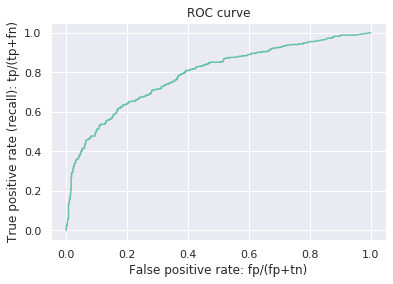

In [81]:
plot_roc(y_test, y_score)

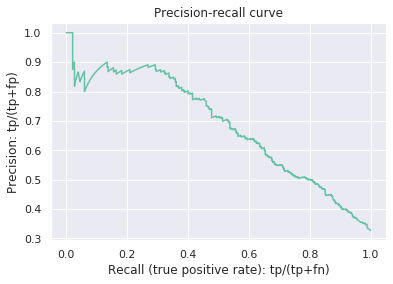

In [82]:
plot_precision_recall(y_test, y_score)

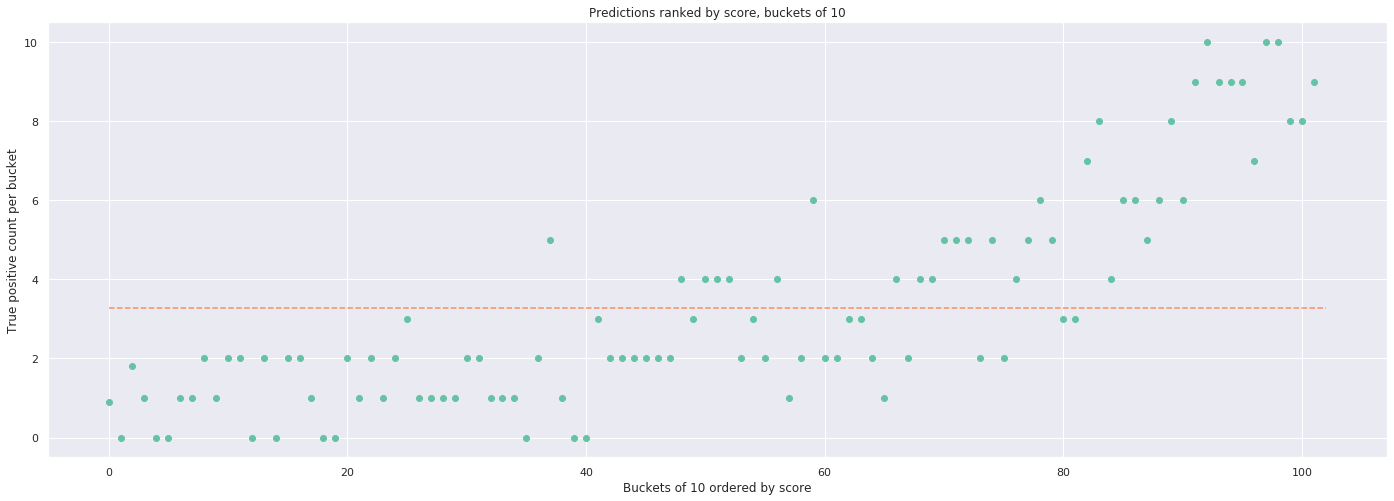

In [83]:
plt.figure(figsize=(24,8))
plot_bucket_counts(y_test, y_score, 10)

In [84]:
feature_importance = pd.DataFrame(forest.feature_importances_, index=colnames, columns=['importance'])
feature_importance.index.name = 'feature'
feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,importance
feature,
exp_yr_num,0.185087
run_single,0.083370
tickets,0.069150
run_team,0.045872
came_from_suggested_job,0.040511
sms_alerts_opt_in,0.037467
van,0.037463
lease_purchase,0.037297
reefer,0.036570
